In [1]:
import numpy as np
from numpy.linalg import eig
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from celmech.nbody_simulation_utilities import set_time_step,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
import rebound
from celmech.disturbing_function import laplace_b as b

In [2]:
from celmech.secular import LaplaceLagrangeSystem
from celmech.poincare import Poincare

In [3]:
def b1(alpha):
    return b(1.5, 1, 0, alpha)
def b2(alpha):
    return b(1.5, 2, 0, alpha)

In [4]:
def make_sim(alpha, mass, ecc, pom):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    mu1, mu2, mu3 = mass
    ecc1, ecc2, ecc3 = ecc
    pomega1, pomega2, pomega3 = pom
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu2, P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.dt = sim.particles[1].P/12
    sim.collision = "direct"
    
    return sim

In [5]:
def norun(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M)
    
    m_tot = ps[1].m + ps[2].m + ps[3].m
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    
    alpha12, alpha23, alpha13 = ps[1].a/ps[2].a, ps[2].a/ps[3].a, ps[1].a/ps[3].a
    ec12 = alpha12**(-1/4)*alpha23**(3/4)*alpha23**(-1/8)*(1-alpha12)
    ec23 = alpha23**(-1/2)*alpha12**(1/8)*(1-alpha23)
    ec13 = alpha13**(-1/2)*(1-alpha13)
    
    # --------------------- calculate the eigenfrequencies ---------------------------------------
    w1 = np.abs(ps[3].n/(2*np.pi)*m_tot*(m1/(m1+m3)/ec12**2+m3/(m1+m3)/ec23**2))
    w2 = np.abs(ps[3].n/(2*np.pi)*m_tot*(m2*(m3/(m1+m3)/ec12**2+m1/(m1+m3)/ec23**2) + (m1+m3)/ec13**2))
    omega1, omega2 = np.abs(vals[0:2])
    
    print(fr"$\omega_1$ from celmech = {omega1}, from approaximation = {w1}, error is {np.abs((omega1-w1)/omega1)}")
    print(fr"$\omega_2$ from celmech = {omega2}, from approaximation = {w2}, error is {np.abs((omega2-w2)/omega2)}")
    
    
    # --------------------- calculate the rotation matrix ------------------------------------------
    R1 = np.array([[np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)],
                   [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
                   [np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)]])

    delta = (ec12 - ec23)/ec13
    denom = 3/16+1/2*(mu3-mu1)*delta+3/8*delta**2-delta**4/16
    phi = -np.sqrt(mu1*mu2*mu3)*delta/denom  # Eq.(26) in paper

    R2 = np.array([[np.cos(phi), -np.sin(phi), 0],
                [np.sin(phi), np.cos(phi), 0],
                [0,0,1]])
    R = R2@R1
    return R

In [6]:
def run(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    R = norun(sim)  # approximated rotation matrix
    
    ec13 = 1-ps[1].a/ps[3].a
    m_tot = ps[1].m + ps[2].m + ps[3].m
    Tsec = 2*np.pi/(1/2*m_tot/ps[0].m/ec13**2)*ps[1].P
    
    Nout = 1000
    times = np.linspace(0,2*Tsec, Nout)
    Gx, Gy = np.zeros((Nout,3)), np.zeros((Nout,3))
    for i, time in enumerate(times):
        sim.integrate(time)
        Gx[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.cos(-p.pomega) for p in ps[1:]]
        Gy[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.sin(-p.pomega) for p in ps[1:]]
    
    Sx = T.T @ Gx.T
    Sy = T.T @ Gy.T

    Sxapprox = R @ Gx.T
    Syapprox = R @ Gy.T
    
    G1, G2, G3 = np.sqrt(Gx**2 + Gy**2).T
    S1, S2, S3 = np.sqrt(Sx**2 + Sy**2)
    S1a, S2a, S3a = np.sqrt(Sxapprox**2 + Syapprox**2)
    
    return times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a

# Test the new S1'

In [7]:
from sympy import *
init_printing()
M1, M2, M3, Mstar, e12, e23, e13, b1_12, b1_23, b1_13, b2_12, b2_23, b2_13, alpha12, alpha23, alpha13, e1, e2, e3 = symbols("m1, m2, m3, Mstar, e_{12}, e_{23}, e_{13}, b1_{12}, b1_{23}, b1_{13}, b2_{12}, b2_{23}, b2_{13}, a_{12}, a_{23}, a_{13}, e_1, e_2, e_3", positive=True, real=True)
eps12, eps23, eps13 = symbols(r"\epsilon_{12}, \epsilon_{23}, \epsilon_{13}", positive=True, real=True)

G = Matrix([sqrt(M1)*e1, sqrt(M2)*e2, sqrt(M3)*e3])

### the eigenmodes by numerically diagonalizing M:

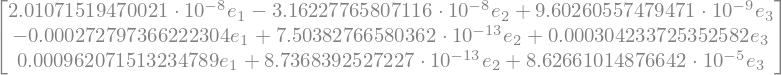

In [8]:
alpha = 0.755, 0.87
mass = 10e-7,1e-15,1e-7
ecc = 0.005, 0.005, 0.005
pomega = -np.pi/3, 0, np.pi/3
sim = make_sim(alpha, mass, ecc, pomega)
ps = sim.particles
lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
M = lsys.Neccentricity_matrix
vals,T = np.linalg.eigh(M)

T.T*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2])

### the calculated eigenmodes:

$\omega_1$ from celmech = 1.809180610546392e-05, from approaximation = 1.846196076617633e-05, error is 0.020459795918364183
$\omega_2$ from celmech = 5.180230070392408e-06, from approaximation = 5.477247694143727e-12, error is 0.9999989426632371


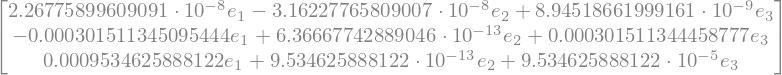

In [9]:
R = norun(sim)
R*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2])

### check with NBody

In [10]:
alpha = 0.945, 0.94
mass = 1e-7,1e-7,1e-7
ecc = 0.005, 0.005, 0.005
pomega = -np.pi/3, 0, np.pi/3
sim = make_sim(alpha, mass, ecc, pomega)

In [11]:
sim = make_sim(alpha, mass, ecc, pomega)
times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a = run(sim)

$\omega_1$ from celmech = 8.646689464488202e-05, from approaximation = 8.36673340333233e-05, error is 0.03237725401214493
$\omega_2$ from celmech = 4.120908158579392e-05, from approaximation = 1.2259836073356826e-11, error is 0.9999997024967411


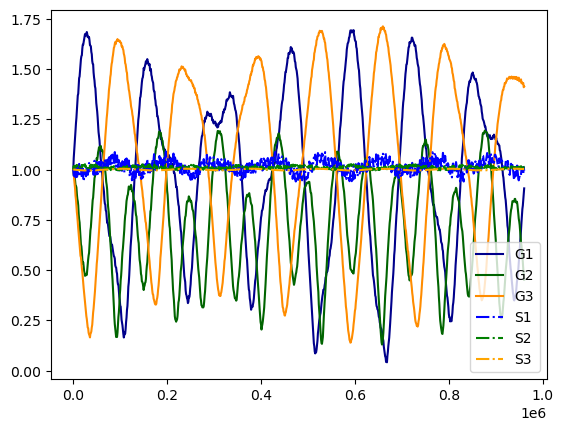

In [12]:
fig, ax = plt.subplots()
ax.plot(times, G1/G1[0], color='darkblue', label='G1')
ax.plot(times, G2/G2[0], color='darkgreen', label='G2')
ax.plot(times, G3/G3[0], color='darkorange', label='G3')
ax.plot(times, S1/S1[0], color='blue', linestyle='-.', label='S1')
ax.plot(times, S2/S2[0], color='green', linestyle='-.', label='S2')
ax.plot(times, S3/S3[0], color='orange', linestyle='-.', label='S3')
ax.legend()

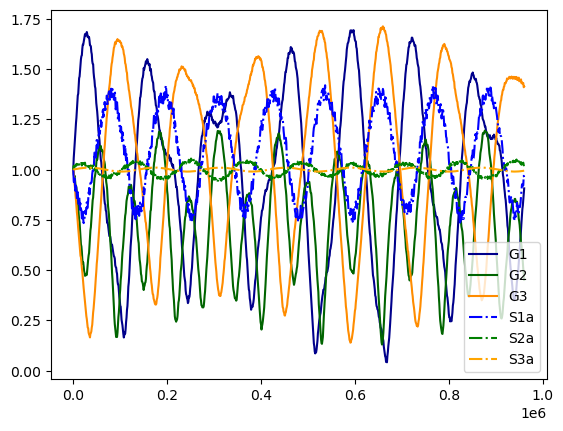

In [13]:
fig, ax = plt.subplots()
ax.plot(times, G1/G1[0], color='darkblue', label='G1')
ax.plot(times, G2/G2[0], color='darkgreen', label='G2')
ax.plot(times, G3/G3[0], color='darkorange', label='G3')
ax.plot(times, S1a/S1a[0], color='blue', linestyle='-.', label='S1a')
ax.plot(times, S2a/S2a[0], color='green', linestyle='-.', label='S2a')
ax.plot(times, S3a/S3a[0], color='orange', linestyle='-.', label='S3a')
ax.legend()

# Test psi approximations

In [14]:
def testPsi(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    ec13 = 1-ps[1].a/ps[3].a
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    m_tot = m1 + m2 + m3
     
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    b12 = alpha12**(1/2)*alpha23**(-3/2)*2/(np.pi*(1-alpha12)**2)
    b23 = alpha23*2/(np.pi*(1-alpha23)**2)
    b13 = alpha13*2/(np.pi*(1-alpha13)**2)
    
    ec12 = alpha12**(-1/4)*alpha23**(3/4)*alpha23**(-1/8)*(1-alpha12)
    ec23 = alpha23**(-1/2)*alpha12**(1/8)*(1-alpha23)
    ec13 = alpha13**(-1/2)*(1-alpha13)
    
    R2 = np.array([[np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)],
                   [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
                   [np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)]])
    
    Mdiagapprox = R2 @ lsys.Neccentricity_matrix @ R2.T
    phi_theo = 1/2*np.arctan(2*Mdiagapprox[1,0]/(Mdiagapprox[1,1]-Mdiagapprox[0,0]))
    
    prefac = - ps[3].n *m_tot/(4*(mu1+mu3))
    w1 = prefac * (mu1*b12 + mu3*b23)
    w2 = prefac * (mu2*mu3*b12 + mu1*mu2*b23 + (mu1+mu3)**2*b13)
    k = prefac * np.sqrt(mu1*mu2*mu3) * (b23*alpha23**(-1/4)-b12*alpha12**(1/4))
    phi_calc = 1/2*np.arctan2(2*k, w2-w1)

    delta = (ec12 - ec23)/ec13
    phi_saa = -np.sqrt(mu1*mu2*mu3/(mu1+mu3)**4)*delta/(3/16+1/2*(mu3-mu1)*delta+3/8*delta**2-delta**4/16)
    
    return delta, phi_theo, phi_calc, phi_saa ,(phi_theo-phi_saa)/phi_theo

In [16]:
mass_param = [[x,y] for x in np.linspace(1,10,2) for y in np.linspace(1,10,2)]
alpha_param = [[x,y] for x in np.linspace(0.75,0.9,4) for y in np.linspace(0.75,0.9,4)]
ecc = 0.005, 0.005, 0.005
pomega = -np.pi/3, 0, np.pi/3

data = np.zeros((100,9))
for i, (alpha1, alpha2) in enumerate(alpha_param):
    for j, (m1, m3) in enumerate(mass_param):
        mass = m1*1e-7, 1e-7, m3*1e-7
        sim = make_sim((alpha1, alpha2), mass, ecc, pomega)
        delta, phi_theo, phi_calc, phi_saa, error = testPsi(sim)

        data[4*i+j][:] = m1, m3, alpha1, alpha2, delta, phi_theo, phi_calc, phi_saa, np.fabs(error)

In [18]:
pd.set_option('display.max_rows', 5)
df = pd.DataFrame(data, columns=['m1', 'm3', 'alpha_12', 'alpha_23', 'delta', '$\phi_{theo}$', '$\phi_{calc}$', '$\phi_{saa}$', 'error'])
df['$\phi_{theo}$'] = df['$\phi_{theo}$'].map('{:e}'.format)
df['$\phi_{calc}$'] = df['$\phi_{calc}$'].map('{:e}'.format)
df['$\phi_{saa}$'] = df['$\phi_{saa}$'].map('{:e}'.format)
df

,m1,m3,alpha_12,alpha_23,delta,$\phi_{theo}$,$\phi_{calc}$,$\phi_{saa}$,error
0,1.0,1.0,0.75,0.75,-0.092649,2.458716e-01,2.068135e-01,2.103569e-01,0.144444
1,1.0,10.0,0.75,0.75,-0.092649,6.962926e-02,6.793511e-02,5.377787e-02,0.227654
...,...,...,...,...,...,...,...,...,...
98,0.0,0.0,0.00,0.00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
99,0.0,0.0,0.00,0.00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
